In [ ]:
!python -m pip install --upgrade pip --quiet

!pip install supervision==0.3.0

!pip install transformers

!pip install pytorch-lightning

!pip install timm

!pip install cython

!pip install pycocotools

!pip install scipy

!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 15.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pytorch-lightning]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 72.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 139.6 MB/s  0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [roboflow]


In [ ]:
import torch
import supervision as sv
import transformers
import pytorch_lightning


In [ ]:
import os
import torchvision
from transformers import DetrImageProcessor

In [ ]:
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="wTfIpt9c8xlbqp1MO2TR")
project = rf.workspace("firas-tlili-twfri").project("bone-fracture-7fylg-shz1l")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bone-fracture-1 in coco:: 100%|██████████| 1104/1104 [00:00<00:00, 8430.12it/s]


In [ ]:
dataset = '/content/bone-fracture-1'

ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target

In [ ]:
TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 964
Number of validation examples: 88
Number of test examples: 44


Image #26


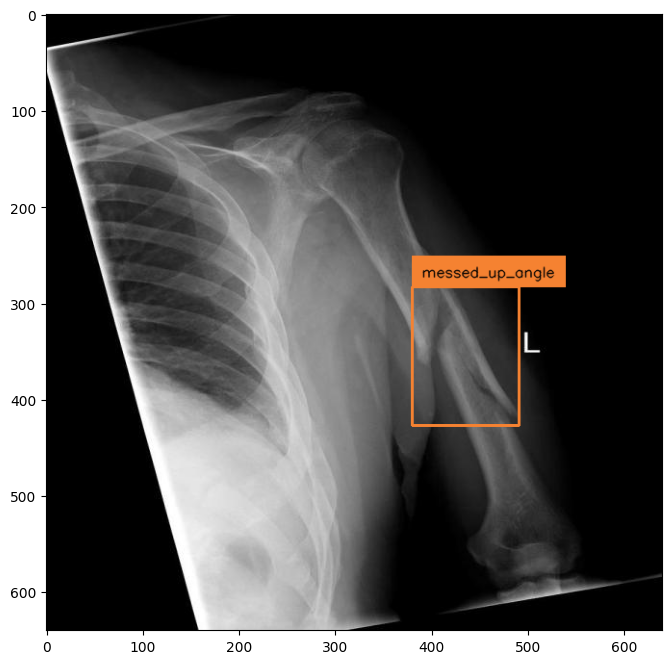

In [ ]:
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (8, 8))

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
for layer1.0.conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass

In [ ]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 20

trainer = Trainer( max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.011   Total estimated model params size (MB)
0         Modules in train mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Found 399 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
MODEL_PATH = 'custom-model'
model.model.save_pretrained(MODEL_PATH)

# loading model
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
for layer1.0.conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

Image #3


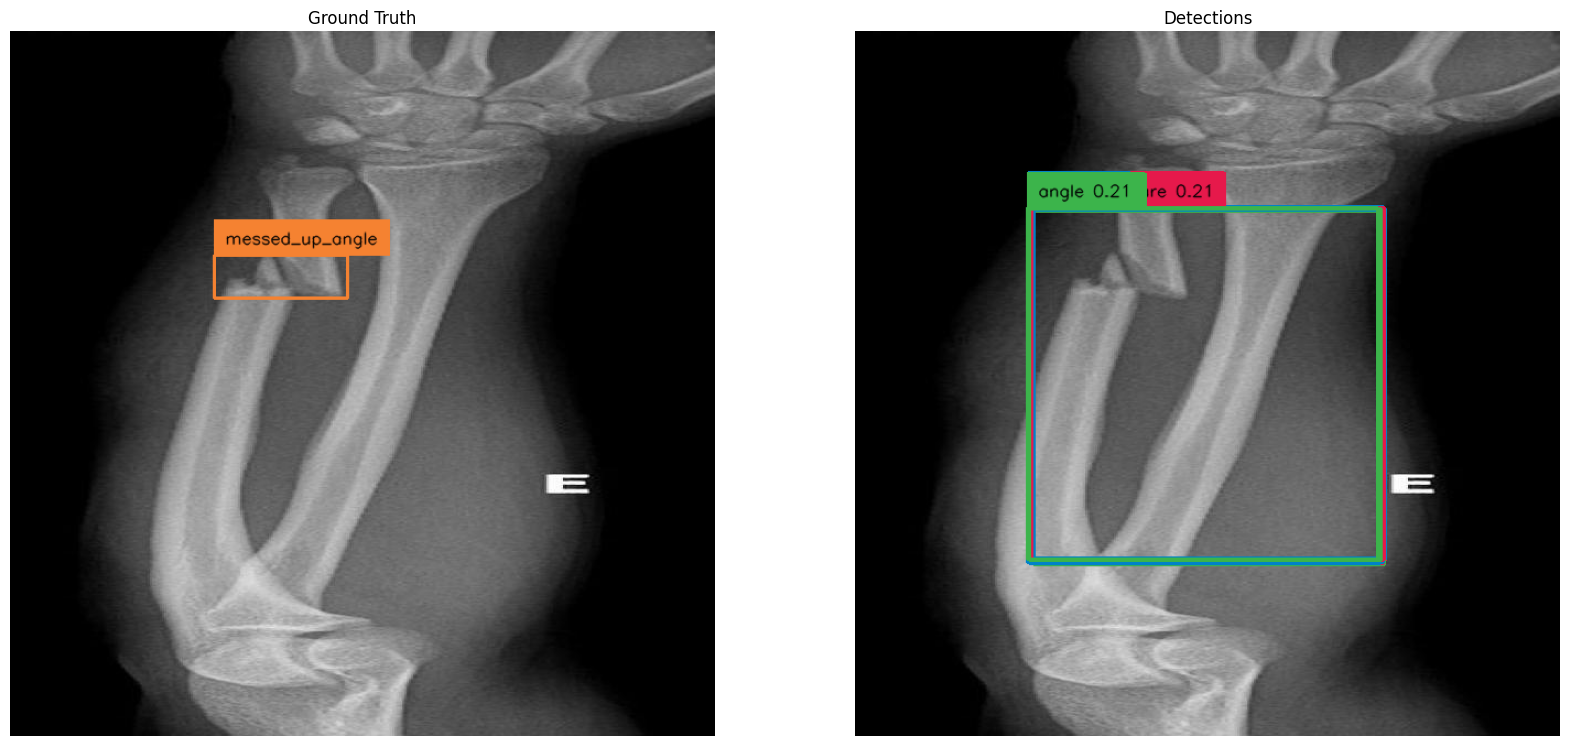

In [ ]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt


# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)
CONFIDENCE_TRESHOLD = 0.1



# Annotate detections
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]


    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


# %matplotlib inline # Remove this line, we won't use it anymore

# Combine both images side by side and display
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()